<a href="https://colab.research.google.com/github/Cognition-And-Vision-Amsterdam-CAVA/UvA2024NeuroAI/blob/main/TutorialDay7_RL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 7: Cognitive maps in brains and models

To navigate the world, animals must learn cognitive maps of their environment, and keep track of their position in it. In this tutorial you will learn how networks of neurons can achieve this feat. More specifically, you will find out how attractor networks perform path integration.

We'll start by plotting the activity of some real rodent neurons, recorded in entorhinal cortex while the animal explores an arena, to get a feeling for the spatial representations that exist in the brain. We'll then build an idealised continuous attractor network, that is designed to use such represenations to keep track of where the agent is. But the weights of our attractor network have been set up to do exactly that - how would you actually learn those weights? To find out, we'll train a recurrent neural network to learn to path integrate from scratch. And maybe, if we open up our trained network, we'll find that it has learned similar representations to the continuous attractor network that we started off with...

The tutorial is structured as follows:
1. **Spatial neural responses, real and simulated**
    - Goals: explore real rodent spatial representations; understand plots of firing rate through space and time.
    - Exercises: plot neural recordings; simulate trajectories and plot simulated responses.
2. **Path integration in continuous attractor networks**
    - Goals: learn how continuous attractor networks implement path integration; understand the details of weights and activities; find out how these produce cell responses and locations estimates.
    - Excercises: build continuous attractor network with appropriate weights and update equations; plot action-dependent weights and transitions; find out how activity moves around.
3. **A recurrent neural network that learns to path integrate**
    - Goals: find out how the weights in (2) can be learned, rather than hand-coded; learn how to train a vanilla recurrent neural network to carry out path integration.
    - Excercises: build a neural network and train it on path integration; implement learnable weights, recurrent dynamics, prediction loss, and the training loop; plot the performance of the resulting model.
4. **Learned representions in trained and ideal networks**
    - Goals: discover the represenations of the trained network; learn how the trained network manages to path-integrate, and find its similarities to the continuous attractor network.
    - Exercises: open up the trained network and plot its representations; compare learned weights and transitions to continuous attractor network; investigate what the dynamics of the learned network look like

This tutorial is in large part built on [NeuralPlayground](https://github.com/SainsburyWellcomeCentre/NeuralPlayground), a library for exploring models of hippocampus and entorhinal cortex. The tutorial has been inspired by, and borrows bits of code from, the [notebook](https://github.com/ganguli-lab/grid-pattern-formation/blob/master/inspect_model.ipynb) and [paper](https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) by Sorscher et al. in Neuron 2023. It also implements methods from the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000291) by Burat and Fiete in PLOS Biology 2009.

The tutorial was developed by Rodrigo Carrasco Davis, Jacob Bakermans, and James Whittington. Feel free to re-use, or get in touch with questions!

#0. **Setup**


In [ ]:
!git clone --branch neuroai_tutorial https://github.com/SainsburyWellcomeCentre/NeuralPlayground
%cd NeuralPlayground
!pip install -e .[dev]

# This will take ~5 minutes

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle
import matplotlib as mpl
import scipy
import copy as cp
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from neuralplayground.experiments import Sargolini2006Data
from neuralplayground.agents import TrajectoryGenerator, Burak2009, Sorscher2022exercise, SorscherIdealRNN
from neuralplayground.utils import PlaceCells, get_2d_sort
from neuralplayground.plotting import plot_trajectory_place_cells_activity, plot_ratemaps, compute_ratemaps
from neuralplayground.config import load_plot_config
load_plot_config()

# 1. **Spatial responses, real and simulated**

## 1.1 Real grid cells
Before doing anything else, run the code block below to download the dataset of single neuron responses during spatial navigation - the download takes about 5 minutes.

In [ ]:
# Download dataset. Takes ~5 min
sargolini_data = Sargolini2006Data(verbose=False)

The dataset that we will be exploring was collected as part of *Sargolini, Francesca, et al. "Conjunctive representation of position, direction, and velocity in entorhinal cortex." Science 312.5774 (2006): 758-762*. In this experiment, the authors record from the medial entorhinal cortex of a rat that explores a 2D arena. The data consists of the (x,y) position of the animal at regular time steps t, and list of timestamps of spikes for a bunch of neurons.

Start by plotting the spikes of all neurons through time. Plot time on the x-axis, neurons as lines on the y-axis, with a dot for each spike (or in other words: plot a dot for each spike at coordinate (spike_time, spike_neuron)). That's called a raster plot.

In [ ]:
# Get recorded cells from one particular session
session_data = sargolini_data.get_recording_data(recording_index=4)[0]
# Extract tracked x,y position of the rat
x = session_data['position']['posx']
y = session_data['position']['posy']
# Get time points that match the x,y position
t = session_data['position']['post']
# Get labels for all neurons measured in this session
neurons = [k for k in session_data.keys() if k not in ['EEG', 'EGF', 'position']]
# Collect time stamps of spikes for those neurons in a list
spikes = [session_data[n] for n in neurons]

# Exercise: make a raster plot

In [ ]:
# @title Solution
# Exercise: make a raster plot
plt.figure()
for i, s in enumerate(spikes):
  plt.scatter(s, np.ones_like(s) * i, marker='.', color=[0,0,0])
plt.xlabel('Time (s)')
plt.ylabel('Neurons')
plt.yticks(np.arange(len(neurons)), neurons);

Now select one neuron and plot the rat's trajectory throught the arena, with a dot at the rat's location whenever that neuron spikes. That gives a rough idea where the neuron likes to fire.

In [ ]:
# Exercise: plot trajectory + spikes

In [ ]:
# @title Solution
# Exercise: plot trajectory + spikes
plt.figure()
plt.plot(x,y, 'k--')
spike_index = [np.array([(np.abs(t - s_i)).argmin() for s_i in s]) for s in spikes]
plt.scatter(x[spike_index[0]], y[spike_index[0]])
plt.xlim([-50,50])
plt.ylim([-50,50])
ax = plt.gca()
ax.set_aspect('equal');

To make this spatial response map of a single neuron more quantitative, it is common to plot *rate maps*. A ratemap divides the environment into bins, and for each bin plots the average firing rate of the neuron while the animal is in that bin.

Advanced: calculate rate maps for the cells we have here.

Alternatively: simply use the provided dataset object to get a ratemap, then plot it.

In [ ]:
# Optional exercise: calculate rate map

# Alternatively, plot ratemap with provided library function
rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(recording_index=4, tetrode_id=neurons[0])

Advanced: how would you define whether from a cell's rate map whether this cell is a grid cell? Can you quantify the 'gridness' of a neuron, to find the prettiest grid cells in all of the dataset? How would you do significance testing on your gridness score?

In [ ]:
# Advanced exercise: calculate a 'grid score' that quantifies grid cell quality

## 1.2 Simulated place cells
To run simulations of spatial representations, we need synthetic neurons and trajectories just like the real ones that we just saw. We'll set them up in this section. First, set some parameters for these simulated neurons and trajectories.

In [ ]:
# Arena dimensions
room_width = 2.2
room_depth = 2.2

# Trajectory parameters
sequence_length = 300
batch_size = 4

# Place cells parameters
n_place_cells = 512
place_cell_rf = 0.12
surround_scale = 2.0
periodic = False
difference_of_gaussians = True

Now generate a population of place cells.

In [ ]:
# Create a population of simulated place cells with the parameters above
place_cells = PlaceCells(Np=n_place_cells,
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale,
                         room_width=room_width,
                         room_depth=room_depth,
                         periodic=periodic,
                         DoG=difference_of_gaussians,
                         device=device)

Set up a trajectory generator and produce one simulated trajectory.

In [ ]:
# Create a generator to sample simulated trajectories with the parameters above
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
# Print the contents of the generated trajectory
for key in traj.keys():
    print(key, traj[key].shape)
# Get the positions
x, y = traj["target_x"], traj["target_y"]


Plot the trajectories that we've just generated.

In [ ]:
# Plotting options
plot_n_trajectories = batch_size
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Now we'll simulate neural activity given the population of synthetic place cells, and the simulated trajectories.

In [ ]:
# Select one trajectory to plot
trajectory_id = 2
trajectory = np.stack([x[trajectory_id, :], y[trajectory_id, :]], axis=1)

# Get place cell activity for each trajectory
pc_inputs, position, pc_outputs = generator.get_test_batch(traj=traj)
# Get center of place field for simulated neurons
place_cells_positions = place_cells.get_place_cell_positions()
# Get firing rates along the current trajectory
pc_rates_trajectories = pc_outputs[:, trajectory_id, :].detach().cpu().numpy().T

Notice how we are now no longer working with discrete spikes, that can occur at any time stamp, but instead we have continuous firing rates for all our cells at regular time steps. This is a much more convenient way of representing neuronal data, because it gives neat rectangular matrices, but of course an abstraction - we are basically discarding fine-grained temporal structure. Let's plot the continuous equivalent of the discrete raster plot that we made for the real neurons, but now for the firing rates of our simulated neurons. Plot neurons on rows with time along the x-axis, but now with a continuous firing rate signal, rather than dots to represent discrete spikes.

In [ ]:
# Exercise: plot continuous raster plot (assume each step takes 0.1s)
# Only include the first 20 cells so it remains somewhat readable

In [ ]:
# @title Solution
# Exercise: plot continuous raster plot (assume each step takes 0.1s)
# Only include the first 20 cells so it remains somewhat readable
n_plot = 20
plt.figure()
for i, r in enumerate(pc_rates_trajectories[:20]):
  plt.plot(np.arange(sequence_length)*0.1, i + r/np.max(pc_rates_trajectories[:20]), 'k')
plt.xlabel('Time (s)')
plt.ylabel('Neurons')

Advanced: also create a discrete raster plot for the same neurons by sampling from a poisson distribution with the given firing rate and time step duration.

Then also create the continous equivalent of the spikes-along-trajectory plot above: the firing rate of the cell at each location along the trajectory.

In [ ]:
# Exercise: plot firing rate along trajectory for one cell
# One way of solving this would be to scatter the trajectory positions,
# with colour defined by firing rate, and a colormap that starts from white

In [ ]:
# @title Solution
# Exercise: plot firing rate along trajectory for one cell
# One way of solving this would be to scatter the trajectory positions,
# with colour defined by firing rate, and a colormap that starts from white
cell_plot=20
plt.figure()
plt.plot(trajectory[:,0], trajectory[:,1], 'k--')
plt.scatter(trajectory[:,0], trajectory[:,1], c=-pc_rates_trajectories[cell_plot], cmap='Reds')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

We'll just do another plot to give you an idea of the activity of the whole simulated population. In the left subplot of this figure, each dot is one place cell. The dot indicates the place cell center (i.e. the location of the peak of the place cell's rate map), and we colour code the place cells by when they are activated along the simulated trajectory. We then plot the firing rates for these neurons through time in a continuous raster plot with matching colours.

In [ ]:
plot_n_cells = 100
raster = True  # Make raster-like plot
log_scale_activity = False

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = plot_trajectory_place_cells_activity(place_cells_center=place_cells_positions,
                                                place_cell_activity=pc_rates_trajectories,
                                                trajectory=trajectory,
                                                ax1=ax1,
                                                ax2=ax2,
                                                plot_n_cells=plot_n_cells,
                                                log_scale=log_scale_activity,
                                                raster=raster)
plt.tight_layout()
plt.show()

And finally, we'll plot some rate maps for the simulated neurons

In [ ]:
# Get place cells rate map
pc_outputs_np = pc_outputs.reshape(-1, n_place_cells).detach().cpu().numpy()
pc = place_cells.grid_pc(pc_outputs_np[::100], res=100)
f, ax = plt.subplots(2, 6, figsize=(12, 5))
ax = ax.flatten()
for i in range(12):
    ax[i].imshow(pc[i], cmap="jet")
    ax[i].axis("off")
plt.suptitle("Place cell rate maps")
plt.tight_layout()
plt.show()

Together, this section should have given you some intuition for the kinds of representations that we find in the brain, and that our models will operate on. We'll need some of our simulated cells and trajectories later!

# 2. **Path integration in continuous attractor networks**

In this section we'll start exploring how networks of neurons can keep track of the agent's or animal's location in space. In other words, these networks need to path-integrate: given an initial position and a velocity signal, they need to update their representation to reflect the resulting new position. The networks that we consider have a very specific set of weights that make them attractor networks. They exhibit a stable 'bump' of activity without velocity input, and can shift the activity bump around when velocitiy comes in. We'll build some intuition of how they can achieve that, first with a simple 1D ring attractor, and then extending the same principles to 2D space.

## 2.1 1D ring attractor intuition

Let's start by setting up our population of neurons for the 1D ring attractor.

In [ ]:
# Number of neurons
N = 100

# Activation function of a single neuron
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


There are two things an attractor network needs to do. The first is that it needs to provide a stable representation the current position on the ring (e.g., head direction). The second is that it needs to be able to change that representation, depending on a velocity signal (e.g., rate of turning head).

Things become a bit easier if we imagine these neurons actually being placed on a ring. They are not actually on a ring, but it's a conceptual trick that will make our lives easier. This conceptual arrangement is called a 'neural sheet'. So when a position on the ring is being represented, then the neurons at that position on the neural sheet will be active - a 'bump' of activity on the neural sheet!

Here's the neural sheet:

In [ ]:
# Plot a little schematic of the neural sheet
x = np.cos(0.5*np.pi - 2*np.pi/N*np.arange(N))
y = np.sin(0.5*np.pi - 2*np.pi/N*np.arange(N))
plt.figure();
# Plot even neurons
plt.scatter(x[0::2], y[0::2], c='r', label='clockwise')
for xs, ys, dx, dy in zip(x[0::2], y[0::2], 0.5*(np.roll(x,-1)[0::2] - x[0::2]), 0.5*(np.roll(y,-1)[0::2] - y[0::2])):
  plt.arrow(xs, ys, dx, dy, color='r', head_width=0.02)
# Plot odd neurons. Decrease radius bit so they don't overlap
x = x*0.95
y = y*0.95
plt.scatter(x[1::2], y[1::2], c='b', label='anticlockwise')
for xs, ys, dx, dy in zip(x[1::2], y[1::2], 0.5*(np.roll(x,1)[1::2] - x[1::2]), 0.5*(np.roll(y,1)[1::2] - y[1::2])):
  plt.arrow(xs, ys, dx, dy, color='b', head_width=0.02)
ax = plt.gca()
ax.set_aspect('equal');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

You see that there are actually two populations of neurons, each arranged on the ring. This is becuause half of the neurons want to push the bump of activity clockwise, and half want to push it anticlockwise. Somehow this all needs to be comtrolled by an external velocity signal. Let's get a bit more formal and workout how this all works.

We'll need to think about the connection weights between these neurons to get a network that path integrates.

To get it to sustain a stable activity bump in the absence of velocity input, we need neurons to excite other neurons near them, while inhibiting neurons further away. A good candidate function for the weights from neuron i to all other neurons j would therefore be $ \cos(\frac{2 \pi (i - j)}{N} ) $. That would produce connectivity for neuron i that maximally excites neuron i itself and its neighbours, inhibits all neurons more than $ N/4 $ places away, and nicely wraps around the 1D ring.

But additionally, we want positive velocity input to shift the activity clockwise, and negative velocity to shift the activity anticlockwise. To achieve that, we'll tweak the weights slightly: *even* neurons shift their excitation a bit to the right, i.e. $ \cos(\frac{2 \pi (i - j + \Delta)}{N} ) $, and *odd* neurons shift their excitation a bit to the left, i.e. $ \cos(\frac{2 \pi (i - j - \Delta)}{N} ) $. If the velocity input signal activates the even neurons for clockwise motion, and the odd neurons for anticlockwise motion, this type of connectivity will move the network activity accordingly.

Write a N x N connectivity matrix $J$ that implements this pattern of connectivity for $\Delta = 7$. We want to update activities $r$ by matrix multiplication $J * r$, so *row* i should hold weights *to* neuron i, and *column* i should hold weights *from* neuron i - in other words, $J_{ij}$ holds the weight *from* neuron j *to* neuron i.

In [ ]:
# Exercise: define connectivity

In [ ]:
# @title Solution
# Exercise: define connectivity
delta = 7  # left-right bias
s = np.arange(N)
beta = delta * (-1)**s
J = np.cos(2 * np.pi / N * (s[None] - s[:, None] + beta))

To make sure the weights look like they should, let's plot them for two neighbouring neurons. Plot outgoing weights (so columns of $J$) for neuron 50 (even neuron, so should shift rightwards) and neuron 51 (odd neuron, so should shift rightwards).

In [ ]:
# Exercise: plot connectivity for a neighbouring left and right neuron


In [ ]:
# @title Solution
# Exercise: plot connectivity for a neighbouring left and right neuron
plt.plot(J[:,int(0.5*N)+0], label='clockwise', c='r')
plt.axvline(x=int(0.5*N), c='r')
plt.plot(J[:,int(0.5*N)+1], label='anticlockwise', c='b')
plt.axvline(x=int(0.5*N)+1, c='b')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

So with our weight matrix all set up, we can start simulating network dynamics. The update equation for our network unit activations is as follows: $ r_t = \sigma(J * r_{t-1} + M * v_t + 1) $, where $\sigma$ is the sigmoid activation that we defined before, $v_t$ is the velocity input, and $M$ indexes whether a neuron is a clockwise or anticlockwise neuron: $M_i=1$ if i is even, and $M_i=-1$ if i is odd. Effectively, this equation therefore implements the recurrent dynamics from our weight matrix $J$, and additionally inhibits one set (e.g. the clockwise) while exciting another set (e.g. the anticlockwise) depending on the input velocity $v_t$

Start by simulating how the network settles into a stable bump of activity when initialised from random activation in absence of a velocity. Concretely: initialise the network with normally distributed random activations, and run the update equation for 1000 iterations with $v_t=0$. Store the activations of each timestep in a list.


In [ ]:
# Exercise: initialise and stabilise network

In [ ]:
# @title Solution
# Exercise: initialise and stabilise network
M  = (-1)**np.arange(N)
r = np.random.randn(N)
v = 0
rs = []
for _ in range(1000):
    r = sigmoid(J @ r + M*v + 1)
    rs.append(r)

In [ ]:
# Plot result (assumes rs contains activations across timesteps)
plt.figure(figsize=(2,4))
plt.imshow(np.stack(rs),aspect='auto');
plt.ylabel('t')
plt.xlabel('Neuron');
plt.title('Activity bump')

OK great it works!

But we don't want to just represent on position on the ring, we want to be able to control that bump of activity. Simulate how the network responds to velocity input, by running the update equation for 10000 iterations with $v_t=2$, then 10000 iterations with $v_t=-2$.


In [ ]:
# Exercise: move the bump around with velocity input,
# starting from the stable representation (r)

In [ ]:
# @title Solution
# Exercise: move the bump around with velocity input,
# starting from the stable representation (r)

# Let's add a velocity signal going clockwise:
v = 2
rs = []
for _ in range(10000):
    r = sigmoid(J @ r + M*v + 1)
    rs.append(r)

# Then a velocity signal going anticlockwise
v = -2
for _ in range(10000):
    r = sigmoid(J @ r + M*v + 1)
    rs.append(r)

In [ ]:
# Plot result
plt.figure(figsize=(2,4))
plt.imshow(np.stack(rs),aspect='auto');
plt.ylabel('t')
plt.xlabel('Neuron');
plt.title('Activity bump')

Play around with this. Does the network always achieve a stable activity bump, or are there requirements for the initial activations? Change the velocity. Can you break the path integrator? Why does it break down?

The activity of the whole network population at each time step is a 100-dimensional vector, because the network has 100 neurons. But you will have probably realised that the actual values that the entries of this vector can take are very constrained: throughout your simulations, you have only encountered very particular 100-dimensional activations. The network states occupy a low-dimensional _subspace_ of all possible 100-dimensional vectors: the dynamics are constrained to a low-dimensional _manifold_. What does this manifold look like? Do a dimensionality reduction using principal component analysis on the [time x neurons] activities that you have just simulated: project the data on the first two principal components to get a [time x 2] matrix, and plot the low-dimensional dynamics.

In [ ]:
# Exercise: do a PCA on the simulated activities to see the manifold

In [ ]:
# @title Solution
# Exercise: do a PCA to see the manifold
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.stack(rs))

two_d = pca.transform(np.stack(rs))

plt.figure()
plt.scatter(*two_d.T)
ax = plt.gca()
ax.set_aspect('equal');
plt.xlabel('PC 1')
plt.ylabel('PC 2')

## 2.2 2D conceptual: neural sheet and weights

Ok we're ready to think about path integrating networks in 2D.

Now rather than having a 1D ring neural sheet, we'll have a 2D neural sheet. Where every 'cluster' of 4 neurons on the sheet are a left/right/up/down neuron. Remember when we visualise the neural sheet, we're really looking at all the neurons activity a for just one particular position in space.

Let's look at this neural sheet

In [ ]:
# Advanced exercise: Make a 2D neural sheet (just use the solution if you're low on time!)

In [ ]:
# @title Solution
L = 24
n_neurons = L**2

# Get sheet locations
grid_location = np.arange(L)
sheet_locations = []
for i in range(L):
    for j in range(L):
        sheet_locations.append(np.array([grid_location[i], grid_location[j]]))
sheet_locations = np.stack(sheet_locations, axis=0)

# Define velocity tuning for each neuron
Mx = np.mod(sheet_locations[:, 1], 2)*((-1)**(sheet_locations[:, 0]))
My = np.mod(sheet_locations[:, 1]+1, 2)*((-1)**(sheet_locations[:, 0]))
Mixy = np.stack([Mx, My], axis=1)

# Plot neural sheet
f, ax = plt.subplots(1, 1, figsize=(6, 6))

# First draw vertical lines for each neuron, such that the intersection correspondes to the neuron location, and put them behind the neurons
for i in range(n_neurons):
    ax.axvline(sheet_locations[i, 0], color="black", linewidth=0.5, zorder=0, alpha=0.5)
    ax.axhline(sheet_locations[i, 1], color="black", linewidth=0.5, zorder=0, alpha=0.5)

# Just colouring each neuron based on its velocity input weights
colors = []
colors_id = {(-1, 0): "C0", (1, 0): "C1", (0, -1): "C2", (0, 1): "C3"}
for i in range(n_neurons):
    colors.append(colors_id[(Mixy[i, 0], Mixy[i, 1])])
ax.scatter(sheet_locations[:, 0], sheet_locations[:, 1], c=colors, s=50)
# Draw small arrow for each neuron, pointing in the direction of Mixy
arrow_size = 0.3
for i in range(n_neurons):
    ax.arrow(sheet_locations[i, 0], sheet_locations[i, 1], Mixy[i, 0]*arrow_size, Mixy[i, 1]*arrow_size, head_width=0.1, head_length=0.1, color=colors[i])

# Adding a legend outside indicating direction based on the color
for key, value in colors_id.items():
    ax.scatter([], [], c=value, label=f"Velocity input {key}")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel("x position [p]")
ax.set_ylabel("y position [q]")
ax.set_title("Location in neural sheet")

OK it's time to play the same game as before. I.e. make each neuron's connectivity be slightly shifted to the left, right, up, or down... depending on whether they are labelled a left, right, up, or down neuron.

This time we want to get grid cells so we'll define the connecticity to be periodic like a grid cell!

For each neuron it'll be:
$J_{ij} = \sum_a \cos (\frac{2*\pi}{L} k_a \cdot (s_i - s_j - \beta_j)$, where $k_a$ are wavevectors for the three cardinal directions of gird cells (0,60,120), $s_i$ is the position on the sheet of neuron i, and $beta_j$ is an offset depending on whether the neuron is a left/right/up/down neuron.

We're not going to get you to code this bit up, but just have a look and try to understand why things look the way they do!

In [ ]:
# Advanced exercise: code this up, and plot the connectivity for neighbouring up/down/left/right neurons.

# (just use the solution if you're low on time!)

In [ ]:
# @title Solution
N = L

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Get sheet positions
delta = 3*N/100  # up/down/left/right bias
s = np.arange(N)
x, y = np.meshgrid(s, s)
x = x.flatten()
y = y.flatten()

# Determining whether it's a left/righ/up/down neuron
M_x = np.mod(y, 2) * (-1)**x
M_y = np.mod(y+1, 2) * (-1)**x

# now we define the connectivity to have a shifted grid-like pattern...
k1 = [np.cos(0*np.pi/3), np.sin(0*np.pi/3)]
k2 = [np.cos(1*np.pi/3), np.sin(1*np.pi/3)]
k3 = [np.cos(2*np.pi/3), np.sin(2*np.pi/3)]
c = 2 * 2 * np.pi / N
delta_x = x[:, None] - x[None] - delta * M_x[None]
delta_y = y[:, None] - y[None] - delta * M_y[None]
J = np.cos(c * (k1[0] * delta_x + k1[1] * delta_y)) + \
    np.cos(c * (k2[0] * delta_x + k2[1] * delta_y)) + \
    np.cos(c * (k3[0] * delta_x + k3[1] * delta_y))

plt.figure(figsize=(12, 3))
color = 'k'
size = 2
loc_x = int(N/2)
loc_y = int(N/2)-1
p = loc_y * N + loc_x
plt.subplot(1,4,1)
plt.imshow(np.reshape(J[:,p+0], (N,N)))
plt.scatter(loc_x,loc_y, c=color, s=size)
plt.title('Right')
plt.subplot(1,4,2)
plt.imshow(np.reshape(J[:,p+1], (N,N)))
plt.scatter(loc_x+1,loc_y, c=color, s=size)
plt.title('Left')
plt.subplot(1,4,3)
plt.imshow(np.reshape(J[:,p+N], (N,N)))
plt.scatter(loc_x,loc_y+1, c=color, s=size)
plt.title('Down')
plt.subplot(1,4,4)
plt.imshow(np.reshape(J[:,p+N+1], (N,N)))
plt.scatter(loc_x+1,loc_y+1, c=color, s=size)
plt.title('Up')

Hopefully you can see two things:

First, because the connectivity has a grid like pattern, there won't just be one bump of activity at any time, there will be many. And they will be in a grid pattern (as neurons try to excite other neurons that are grid-cell like vectors away). This is what get's grid cells.

Second, that these bumps of activity get pushed around by the shifted connectivity matrices, i.e.. the right neurons will try to push activity to the right and so on.

So this should mean we're ready to build a 2D attractor network



## 2.3 Path integrate Ideal RNN

So actually building an attractor that path integrates in 2D can be a bit finickity... So we're going to give you access to the original grid cell model by Burak and Fiete from *Burak, Yoram, and Ila R. Fiete. "Accurate path integration in continuous attractor network models of grid cells." PLoS computational biology 5.2 (2009): e1000291.*

In [ ]:
n_neurons = 2**7
ideal_RNN = Burak2009(n_neurons=n_neurons, compute_sorscher_weights=False)
# help(Burak2009)

periodic_grid_cell = ideal_RNN.ideal_grid_cells(periodic_boundary = True)

Let's look at the activity of neurons on the neural sheet, and zoom into a unit square that we'll keep looking at

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(periodic_grid_cell, cmap="jet")
ax[0].axis("off")
ax[0].set_title("Neural sheet activity")

square_center = 80, 74
half_square_size = 20
# Draw a red square around square center of size 40 by 40
ax[0].plot(
    [square_center[1]-half_square_size, square_center[1]-half_square_size, square_center[1]+half_square_size, square_center[1]+half_square_size, square_center[1]-half_square_size],
    [square_center[0]-half_square_size, square_center[0]+half_square_size, square_center[0]+half_square_size, square_center[0]-half_square_size, square_center[0]-half_square_size],
            color="red", linewidth=2)

# Imshow the activity of the grid cell just within the square
ax[1].imshow(periodic_grid_cell[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[1].axis("off")
ax[1].set_title("Zoomed")

Now let's see how the activity of the neurons in this region of the neural sheet change when moving right

In [ ]:
n_steps = 10
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.1  # 1cm/s

f, ax = plt.subplots(2, 5, figsize=(5*n_steps//2, 4*2))
ax = ax.flatten()

neuron_response = cp.deepcopy(periodic_grid_cell)
time = 0
for i in range(n_steps):
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.zeros(inner_steps), # Head direction is in radians, so this is moving to the right
                                                velocity=np.ones(inner_steps)*0.01,
                                                grid_cell_rate=neuron_response)
    ax[i].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[i].set_title(f"{time} ms, {velocity_size} cm/s, right")
    time += ideal_RNN.time_step_dt*inner_steps
    ax[i].axis("off")
plt.tight_layout()
plt.show()

And now moving up

In [ ]:
n_steps = 10
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.01  # 1cm/s

f, ax = plt.subplots(2, 5, figsize=(5*n_steps//2, 4*2))
ax = ax.flatten()

neuron_response = cp.deepcopy(periodic_grid_cell)
time = 0
for i in range(n_steps):
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*np.pi/2, # Head direction is in radians, so this is moving up
                                                velocity=np.ones(inner_steps)*0.01,
                                                grid_cell_rate=neuron_response)
    ax[i].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[i].set_title(f"{time} ms, {velocity_size} cm/s up", loc="right")
    time += ideal_RNN.time_step_dt*inner_steps
    ax[i].axis("off")
plt.tight_layout()
plt.show()

And now let's look at all directions

In [ ]:
inner_steps = 600  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.01  # 1cm/s

f, ax = plt.subplots(3, 3, figsize=(8, 8))

time = 0
response_per_direction = []

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
dir_titles =      ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]

neuron_response = cp.deepcopy(periodic_grid_cell)
ax[1, 1].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[1, 1].axis("off")
for i in range(len(head_directions)):
    neuron_response = cp.deepcopy(periodic_grid_cell)
    hd = head_directions[i]
    axi, axj = subplot_coordinates[i]
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*hd, # Head direction is in radians, so this is moving up
                                                  velocity=np.ones(inner_steps)*velocity_size,
                                                  grid_cell_rate=neuron_response)
    ax[axi, axj].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                        square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[axi, axj].axis("off")
    # Draw an arrow from the central plot to the next plot according to its head direction
    ax[axi, axj].set_title("$\Delta$ "+dir_titles[i], loc="center")

plt.tight_layout()
plt.show()

To get more intuition for how these networks work, we can look at the pattern of excitation and inhibition on each bump the network uses to moves the bump around

In [ ]:
inner_steps = 500  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.05  # 5cm/s

f, ax = plt.subplots(3, 3, figsize=(8, 8))

neuron_response = cp.deepcopy(periodic_grid_cell)
time = 0
response_per_direction = []

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]

half_square_size = 8
ax[1, 1].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[1, 1].axis("off")
for i in range(len(head_directions)):
    neuron_response = cp.deepcopy(periodic_grid_cell)
    hd = head_directions[i]
    axi, axj = subplot_coordinates[i]
    _, pattern_change = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*hd, # Head direction is in radians, so this is moving up
                                                  velocity=np.ones(inner_steps)*velocity_size,
                                                  grid_cell_rate=neuron_response,
                                                  get_pattern_change=True)
    ax[axi, axj].imshow(pattern_change[square_center[0]-half_square_size:square_center[0]+half_square_size,
                                     square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="coolwarm")
    ax[axi, axj].axis("off")
    # Draw an arrow from the central plot to the next plot according to its head direction
    ax[axi, axj].set_title(dir_titles[i], loc="center")
plt.tight_layout()
plt.show()

We see that to move a bump to the left, it excites the neurons to the left and inhibits the neurons to the right... just as the connectivity says it should!

## 2.4 Trajectories

Now lets look at the activity of a cell while the network is path integrating on a specific trajectory. First, generate the trajectory.

In [ ]:
# Generate a trajectory following base code to get the same results
# This trajectory is simulated using an enclosure radios of 2 meters
example_trajectory_size = 100000
position_x, position_y, headDirection = ideal_RNN.simulate_base_trajectory(sequence_length=example_trajectory_size)


In [ ]:
# Plot the trajectory
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(position_x, position_y)
ax.set_xlabel("Pos x [cm]")
ax.set_ylabel("Pos y [cm]")
ax.set_title("Simulated trajectory (orig paper)")
plt.show()

Then provide this trajectory as input to the model. We'll let it path-integrate while recording neural activities, so we can plot those afterwards.

In [ ]:
# @title Path integrate while recording

from scipy.fft import fft2, fftshift, ifft2

def path_neural_activity(ideal_rnn_, position_x, position_y, headDirection, grid_cell_rate, periodic_boundary=False):
  increment = 1
  r = grid_cell_rate
  sampling_length = len(position_x)
  single_neuron_response = np.zeros(sampling_length)
  single_neuron = [ideal_rnn_.n_neurons // 2, ideal_rnn_.n_neurons // 2]

  # ADDED THIS: store firing rate of whole population
  frs = [grid_cell_rate]

  for iter in tqdm(range(sampling_length - 20)):
      theta_v = headDirection[increment]
      vel = np.sqrt(
          (position_x[increment] - position_x[increment - 1]) ** 2
          + (position_y[increment] - position_y[increment - 1]) ** 2
      )

      left = -np.cos(theta_v)
      right = np.cos(theta_v)
      up = np.sin(theta_v)
      down = -np.sin(theta_v)

      increment += 1

      # Break feedforward input into its directional components
      # Equation (4)
      rfield = ideal_rnn_.venvelope * (
          (1 + ideal_rnn_.alpha * vel * right) * ideal_rnn_.typeR
          + (1 + ideal_rnn_.alpha * vel * left) * ideal_rnn_.typeL
          + (1 + ideal_rnn_.alpha * vel * up) * ideal_rnn_.typeU
          + (1 + ideal_rnn_.alpha * vel * down) * ideal_rnn_.typeD
      )

      # Convolute population activity with shifted symmetric weights.
      # real() is implemented for octave compatibility
      convolution = np.real(
          ifft2(
              fft2(r * ideal_rnn_.typeR) * ideal_rnn_.ftr_small
              + fft2(r * ideal_rnn_.typeL) * ideal_rnn_.ftl_small
              + fft2(r * ideal_rnn_.typeD) * ideal_rnn_.ftd_small
              + fft2(r * ideal_rnn_.typeU) * ideal_rnn_.ftu_small
          )
      )

      # Add feedforward inputs to the shifted population activity to
      # yield the new population activity.
      rfield += convolution

      # Neural Transfer Function
      fr = np.maximum(rfield, 0)

      # Neuron dynamics (Eq. 1)
      r_old = r
      r_new = np.minimum(10, (ideal_rnn_.time_step_dt / ideal_rnn_.tau) * (5 * fr - r_old) + r_old)
      r = r_new

      # Track single neuron response
      if fr[single_neuron[0], single_neuron[1]] > 0:
          single_neuron_response[increment] = fr[single_neuron[0], single_neuron[1]]

      # ADDED THIS: every 10 steps, store firing rate of whole population
      if iter % 10 == 0:
        frs.append(fr)

  # ADDED THIS: return firing rate of whole population
  return single_neuron_response, r, frs

In [ ]:
# Path integrate along generated trajectory, while recording neural activity.
# This takes ~5 mins
grid_rate = periodic_grid_cell
neuron_response, grid_rate, frs = path_neural_activity(
    ideal_RNN, position_x,
    position_y,
    headDirection,
    grid_rate,
    periodic_boundary=False)

In [ ]:
# Plot firing rate along trajectory (like you did in section 1.2)
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlabel("Pos x [cm]")
ax.set_ylabel("Pos y [cm]")
ax.set_title("Single cell activity")

sub_sample_index = np.arange(0, len(neuron_response), 20)
activitiy_rate_sampled = neuron_response[sub_sample_index]
subsample_x = position_x[sub_sample_index]
subsample_y = position_y[sub_sample_index]
colors = plt.cm.jet(neuron_response/np.max(neuron_response))
subsample_colors = colors[sub_sample_index]

ax.scatter(subsample_x, subsample_y, c=subsample_colors, s=5)
ax.axis("equal")

plt.tight_layout()
plt.show()

And like in the 1D case, we can now investigate the low-dimensional manifold that of the neural activity. Like before, we have just simulated vectors of population activity, which have very high dimensionality - 128*128 = 16384 in this case! But the actual latent dynamics occur on a much lower dimensional manifold. Let's look at the manifold of the neural activity by projecting it on the first three principal components.

In [ ]:
# We have a list of firing rates of all (n_neurons x n_neurons) neurons on the neural sheet along the trajectory
# Stack them to get a [time x n_neurons x n_neurons] matrix,
# then prepare for PCA by flattening the neural sheet to [time x (n_neurons * n_neurons)],
# then sub-sample to make this a bit faster
frs_pca = np.reshape(np.stack(frs), (-1, n_neurons*n_neurons))[::5]

# Exercise: do a PCA to see the 3-dimensional manifold

In [ ]:
# @title Solution
# Exercise: do a PCA to see the 3-dimensional manifold
pca = PCA(n_components=3)
pca.fit(frs_pca)

three_d = pca.transform(frs_pca)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*three_d.T)

That kind of looks like a torus... Which is exactly what the manifold of real grid cells looks like! Sorry for the tiny image, it won't paste here if it's larger - see full figure [here](https://www.nature.com/articles/s41586-021-04268-7/figures/1).

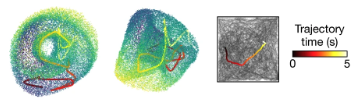

# 3. **A recurrent neural network that learns to path integrate**

The previous section described how a recurrent neural network could track location, with a very specific set of hand-tuned connection weights. While that is great to get an intuition for how a neural network *could* solve this problem, the question remains if that's what a network that has to learn to path-integrate actually *does*. We'll find out in the following sections! In this section, we'll train a RNN to accurately path integrate.

We'll give you two options for completing this section: you can either code up your own RNN and train it (option A), or use a model that we have implemented and trained for you (option B). Since training will take ~20 mins, you may also want to consider building you own model, but then using the pretrained model for further analysis. Up to you.

Below you will find some hyperparameters for the model.

In [ ]:
# Real RNN parameters (pre-trained models use this number of neurons)
n_grid_cells = 24**2  # needs to be the square of a number for later analysis
learning_rate = 5e-4
training_steps = int(5e4) # the pre-trained model is trained for 1e5 iterations, which takes 40 mins. To save time, we'll do 5e4 iterations
weight_decay = 1e-4
sequence_length = 20

# If you are loading a pre-trained model, make sure to use the same activation function
# activation = "tanh"  # This will give you "square grids", some of them actually look hexagonal
activation = "relu"  # This will give you hexagonal grids

The objective of this model will be to track the animal's position. More specifically, that means predicting where it will end up given a velocity signal. Concretely, the model receives a velocity input at each step, and based on its hidden state and recurrent weights, provides a position estimate as output. That output position estimate comes in the form of a vector of place cell activities. The recurrent units are interpreted as grid cells, so the hidden state corresponds to grid cell activity.

To train such a model, we need training data that consists of trajectories (for input) and corresponding place cell activations (as target output). That's exactly what we have been simulating in section 1.2. There will be one difference: the trajectories will be much shorted, because we will need to backpropagate-through-time.

In [ ]:
# Now we try shorter sequences to train an RNN using backpropagation through time
sequence_length = 20
batch_size = 256

# Create a new generator for generating trajectories to train the model on
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
# We can apply "next" operator to sample trajectory batches and place cells activity
gen = generator.get_batch_generator()

# Plotting options
plot_n_trajectories = 15
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot a batch of example trajectories
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 3.1 [A] Train your own path integrator
Below you will find the skeleton of an RNN, where you will need to implement the essential parts to make it path integrate.

We'll build it up step by step:
- The first function you'll encounter is *_initialize_weights(self)*, which initialises a bunch of model weights - the next functions will let you know what weights we're talking about, so skip it for now. When you get back to this function to initialise weight matrices, you would ideally use uniform random initialization, between $ -\sqrt{input}, +\sqrt{input} $.
- The central function that implements the recurrent dynamics is *g(self,inputs)*. It receives a tuple of a [time steps x batch x 2] dimensional velocity signal $ v $, and a [batch x place cells] dimensional initial position code $ p $. The output is the corresponding recurrent unit (i.e. grid cell) activity across time steps $ g $, with shape [time steps x batch x grid cells]. You will need to:
  - Initialise the recurrent unit activity from the initial place cell input using encoder weights $ W_e $, initialised by you in *_initialise_weights(self)*
  - For each time step (*self.sequence_length* of them), calculate the updated recurrent activity through $ g_t = f(W_v * v_t + W_g * g_{t-1}) $, where
    - $ f $ is a non-linearity, initalised already, use *self.non_linearity*
    - $ W_v $ are weights from velocity to grid cells, initialised by you in *_initialise_weights(self)*
    - $ W_g $ are recurrent weights from grid cells to grid cells, initialised by you in *_initialise_weights(self)*
- The function *predict(self, inputs)* then calls this recurrent update with the same inputs, and outputs predicted positions as place cell activations $ p_t = W_d * g_t $. $ W_d $ is a matrix of decoder weights, initialised by you in *_initialise_weights(self)*. The output place cell activations have dimensions [time steps x batch x place cells].
- The function *compute_loss(self, inputs, pc_outputs, pos)* calls the prediction function to calculate the training loss for the predicted place cell activities. The *pc_outputs* input is a [time steps x batch x place cells] matrix of ground truth place cell activity. The *pos* input is a [time steps x batch x 2] ground truth location matrix. The function returns two outputs:
  - loss: $ l = l_p + l_w $, where
    - $ l_p = mean(-\Sigma_p y_p * log(\hat{y}_p)) $ is a prediction loss that calculates the cross-entropy loss between predicted and ground truth place cell activities, averaged across time steps and batches. We get $\hat{y}$ by taking the softmax over the output of *predict(inputs)*.
    - $ l_w = sum(w * W_g^2) $ implements weight regularisation, where $w$ is a decaying regularisation factor, implemented already as *self.weight_decay*, and the square is the element-wise square of the recurrent weight matrix.
  - error: the distance between the 2D coordinate of the agent according to the place cell activation from *predict(inputs)* and the ground truth coordinate in *pos*, averaged across time and batches. You'll get the 2D coordinate given place cell predictions with *self.place_cells.get_nearest_cell_pos(predictions)*
- The function *bptt_update(self, inputs, pc_outputs, pos)* will then take the loss outputs and carry out backpropagation through time. You'll need to reset the gradients of the optimiser, already initialised as *self.optimizer*, then calculate the losses with *compute_loss(inputs, pc_outputs, pos)*, do the backward pass, and step the optimiser. The outputs of this function are simply the loss and the error, but in numpy format (without gradients, on the cpu - so you'll need *.detach().cpu().numpy()*) for further processing.
- Finally, the *train_RNN(self, data_generator, training_steps)* function repeats the backprop operation for the number of training iterations required. The *data_generator* input is the generator that we've seen before, to produce trajectories and corresponding place cell activations; the *training_steps* input is the number of training iterations. Write a training loop that samples new inputs and targets from the generator using *inputs, pc_outputs, pos = next(data_generator)*, and append the outputs of the backprop-through-time to lists that track training progress: *self.loss_hist* (already initialised) for losses, and *self.pos_err_hist* (already initialised) for position estimate error. The function returns the both training history lists after finishing the training loop.

In [ ]:
class MyPathIntegrator(Sorscher2022exercise):

    def __init__(
            self, Ng, Np, sequence_length, weight_decay, place_cells, device,
                activation=torch.nn.ReLU, learning_rate=5e-3, learning_rule="adam"
        ):
        super().__init__(Ng, Np, sequence_length, weight_decay, place_cells, device, activation, learning_rate, learning_rule)

    def _initialize_weights(self):
        # Exercise: intialise weights

    def g(self, inputs):
        # Exercise: do recurrent update
        return g_cell_activity

    def predict(self, inputs):
        # Exercise: predict place cell activity
        return pred_place_cells

    def compute_loss(self, inputs, pc_outputs, pos):
        # Exercise: calculate losses
        return loss, err

    def bptt_update(self, inputs, pc_outputs, pos):
        # Exercise: backpropagate through time
        return loss.detach().cpu().numpy(), err.detach().cpu().numpy()

    def train_RNN(self, data_generator, training_steps):
        # Exercise: run training loop
        return self.loss_hist, self.pos_err_hist

In [ ]:
# @title Solution
class MyPathIntegrator(Sorscher2022exercise):

    def __init__(
            self, Ng, Np, sequence_length, weight_decay, place_cells, device,
                activation=torch.nn.ReLU, learning_rate=5e-3, learning_rule="adam"
        ):
        super().__init__(Ng, Np, sequence_length, weight_decay, place_cells, device, activation, learning_rate, learning_rule)

    def _initialize_weights(self):
        # Exercise: intialise weights

        k_g = 1/self.Ng
        k_p = 1/self.Np
        np_encoder_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, self.Np))
        recurrent_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, self.Ng))
        np_velocity_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, 2))
        np_decoder_W = np.random.uniform(-np.sqrt(k_p), np.sqrt(k_p), size=(self.Ng, self.Np))

        self.encoder_W = torch.nn.Parameter(torch.tensor(np_encoder_W, dtype=self.dtype, device=self.device),
                                            requires_grad=True)
        self.recurrent_W = torch.nn.Parameter(torch.tensor(recurrent_W, dtype=self.dtype, device=self.device),
                                              requires_grad=True)
        self.velocity_W = torch.nn.Parameter(torch.tensor(np_velocity_W, dtype=self.dtype, device=self.device),
                                             requires_grad=True)
        self.decoder_W = torch.nn.Parameter(torch.tensor(np_decoder_W, dtype=self.dtype, device=self.device),
                                            requires_grad=True)

        self.softmax = torch.nn.Softmax(dim=-1)

    def g(self, inputs):
        # Exercise: do recurrent update

        velocity, init_place_cell = inputs
        initial_states = init_place_cell @ self.encoder_W.T

        batch_size = velocity.shape[1]
        h_t_minus_1 = initial_states
        h_t = initial_states
        g_cell_activity = []
        for t in range(self.sequence_length):
            linear_input = velocity[t] @ self.velocity_W.T + h_t_minus_1 @ self.recurrent_W.T
            h_t = self.non_linearity(linear_input)
            g_cell_activity.append(h_t)
            h_t_minus_1 = h_t
        g_cell_activity = torch.stack(g_cell_activity)
        return g_cell_activity

    def predict(self, inputs):
        # Exercise: predict place cell activity

        g_cell_activity = self.g(inputs)
        pred_place_cells = g_cell_activity @ self.decoder_W
        return pred_place_cells

    def compute_loss(self, inputs, pc_outputs, pos):
        # Exercise: calculate losses

        y = pc_outputs
        preds = self.predict(inputs)
        yhat = self.softmax(self.predict(inputs))
        loss = -(y * torch.log(yhat)).sum(-1).mean()

        loss += self.weight_decay * (self.recurrent_W**2).sum()

        pred_pos = self.place_cells.get_nearest_cell_pos(preds)
        err = torch.sqrt(((pos - pred_pos) ** 2).sum(-1)).mean()

        return loss, err

    def bptt_update(self, inputs, pc_outputs, pos):
        # Exercise: backpropagate through time

        self.optimizer.zero_grad()
        loss, err = self.compute_loss(inputs, pc_outputs, pos)
        loss.backward()
        self.optimizer.step()

        return loss.detach().cpu().numpy(), err.detach().cpu().numpy()

    def train_RNN(self, data_generator, training_steps):
        # Exercise: run training loop

        for i in tqdm(range(training_steps)):
            inputs, pc_outputs, pos = next(data_generator)
            loss, pos_err = self.bptt_update(inputs,pc_outputs,pos)
            self.loss_hist.append(loss)
            self.pos_err_hist.append(pos_err)

        return self.loss_hist, self.pos_err_hist

Create instance of the model you've just built:

In [ ]:
real_rnn = MyPathIntegrator(Ng=n_grid_cells,
                                Np=n_place_cells,
                                sequence_length=sequence_length,
                                weight_decay=weight_decay,
                                place_cells=place_cells,
                                activation=activation,
                                learning_rate=learning_rate,
                                device=device)

## 3.1 [B] Construct a pre-built path integrator model

Create instance of provided model. If you want to find out what's happening under the hood, have a look at the _Sorscher2022exercise_ class [here](https://github.com/SainsburyWellcomeCentre/NeuralPlayground/blob/neuroai_tutorial/neuralplayground/agents/Sorscher_2022.py).

In [ ]:
real_rnn = Sorscher2022exercise(Ng=n_grid_cells,
                                Np=n_place_cells,
                                sequence_length=sequence_length,
                                weight_decay=weight_decay,
                                place_cells=place_cells,
                                activation=activation,
                                learning_rate=learning_rate,
                                device=device)

## 3.2 Train the model

If you're going to train your own model, you'll want to start a GPU session on colab, because it's ~50x faster. Go to Runtime > Change runtime type > Pick a GPU. That will disconnect your runtime so you'll have to rerun certain sections. Just collapse the section by clicking the V button next to the section heading, then click play to execute all of the section's cells. To start training, rerun Section 0 (to set up packages), Section 1.2 (to create trajectory generator), and Section 3 up to here (to define your model).

In [ ]:
# Change do_train to true if you have built your own RNN (Option B). Else, load trained weights (Option A)
do_train=False
if do_train:
  loss_hist, pos_err_hist = real_rnn.train_RNN(gen, training_steps)
else:
  real_rnn.load_model(f"examples/neuroai_tutorial/tmp_tutorial_model/long_pre_trained_{activation}.tar")

Let's have a look at the training curve, to find out whether the loss has coverged after training, and if the model has learned to accurately track its position. We'll plot the loss (cross-entropy loss between true and predicted place cell activity) and the position error (distance between true location and location according to place cell activation) against training iterations. If they don't look like they have flattened, we're in trouble... We might need more training iterations in that case.

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
# Loss across training
ax[0].plot(real_rnn.loss_hist)
ax[0].set_xlabel("Training steps")
ax[0].set_ylabel("Loss")
# Position error across training
ax[1].plot(real_rnn.pos_err_hist)
ax[1].set_xlabel("Training steps")
ax[1].set_ylabel("Position error")
plt.tight_layout()
plt.show()

## 3.3 Plot performance and learned neurons

Alright, we now have a trained model! Let's see how it performs. We'll generate some more training examples, feed them to the model, and inspect the model outputs. Plot some true and model predicted trajectories to see if the model is capable of path integration - in other words, whether it accurately tracks position from velocity input. There's a small caveat for the inpretation of this plot, because we use a very rudimentary way of translating predicted place cell activity to 2d coordinates: we just average the coordinate of the peak of the place cells that respond strongest (using [get_nearest_cell_pos](https://github.com/SainsburyWellcomeCentre/NeuralPlayground/blob/c4fb977de6420e5c24621fe7199d668f41c5919b/neuralplayground/vendored/place_cells.py#L79)). So don't be disheartened if the true and predicted trajectories don't perfectly overlap.

In [ ]:
# Create a new set of model inputs.
# inputs: tuple of [time steps x batch x 2] velocity signal,
#   and [batch x place cells] initial position code
# pos: [time steps x batch x 2] 2d coordinates that form trajectories
# pc_outputs: [time steps x batch x place cells] ground truth place cell activity
inputs, pos, pc_outputs = generator.get_test_batch()

# Get model predicted position by having the model predict place cell activities
# based on initial place cells activity and velocity signal (both in inputs)
# Then translate those predicted activities to 2d coordinates based on place cell locations
pred_pos = place_cells.get_nearest_cell_pos(real_rnn.predict(inputs)).cpu()

# Get true position to gpu, and position of all place cells
pos = pos.cpu()
cell_pos = place_cells.cell_positions.cpu()

# Exercise: plot 10 ground truth trajectories, and the corresponding predicted trajectories
# Also scatter the peak locations of all place cells, to get an idea of the coverage

In [ ]:
# @title Solution
# Exercise: plot 10 ground truth trajectories, and the corresponding predicted trajectories
# Also scatter the peak locations of all place cells, to get an idea of the coverage
n_trajectories = 10
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colors = plt.cm.viridis(np.linspace(0, 1, sequence_length))
for i in range(n_trajectories):
    ax.plot(pos[:,i,0], pos[:,i,1], c='red', label='True position', linewidth=2)
    ax.plot(pred_pos[:,i,0], pred_pos[:,i,1],
             c="blue", label='Decoded position')
    ax.scatter(pred_pos[:,i,0], pred_pos[:,i,1], c=colors, s=50, label='place_cells')
    if i==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.scatter(cell_pos[:,0], cell_pos[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_xlim([-room_depth/2,room_width/2])
ax.set_ylim([-room_depth/2,room_depth/2]);

And now we can also investigate the representations that the model has learned. What do the rate maps of our recurrent units look like? We'll generate trajectories, input them to the model, run the model while collecting its hidden unit activations, then average the firing rate across trajectories for each binned position to get rate maps (see [compute_ratemaps](https://github.com/SainsburyWellcomeCentre/NeuralPlayground/blob/c4fb977de6420e5c24621fe7199d668f41c5919b/neuralplayground/vendored/visualize.py#L65)) just like we did for real neurons in section 1.1. And (drum roll...) they look like grid cells!

In [ ]:
# Collect hidden unit activations to produce rate maps (takes ~1 min)
res = 50
n_avg = 100
Ng = n_grid_cells
activations, rate_map, g, pos = compute_ratemaps(real_rnn,
                                                 generator,
                                                 sequence_length,
                                                 batch_size,
                                                 room_width,
                                                 room_depth,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=n_grid_cells)
# Plot rate maps
n_plot = 256
plt.figure(figsize=(16, 4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

Advanced: if you ended up inventing a clever way of quantifying grid cells in section 1.1, try to apply your 'grid score' to the learned artificial neurons. How do they compare to real grid cells?

In [ ]:
# Advanced exercise: calculate grid scores for learned artificial neurons

# 4. **Learned representions in trained networks**

Now that we have trained a RNN to path integrate, we can look under the hood and see how exactly it does so. We'll make plots like the ones we made to understand the ideal, hand-wired attractor network from section 2, and see if the trained network shares some of the features that we investigated in the 2D attractor network.

## 4.1 Neural sheet

But before we can make similar plots to those from section 2, we'll need to do a bit of pre-processing on the learned rate maps. Many of our intuitions came from the conceptual neural sheet, but the learned RNN doesn't have a pre-specified neural sheet: we didn't set up any particular organisation of its neurons. Because we didn't predefine where on the neural sheet the RNN neurons are, we are going to have to post-hoc work out the effective locations on a neural sheet the RNN has learned.

We refer the interesed reader to equations 39-42 in [Sorscher et al 2023](https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) to understand how to do this... First we find the phase of each grid cell along the three ($0^o, 60^o, 120^o$) grid axes (remember, grid cells are periodic, so you can define their response pattern by three phases: where do they peak with respect to some reference, along each of the three grid axes).

In [ ]:
# Fourier transform
Ng = n_grid_cells
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

# Computing fourier transform to get phases
for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))

rm_fft = rm_fft_real + 1j * rm_fft_imag

k1 = [3,0]
k2 = [2,3]
k3 = [-1,3]
k4=k5=k6=k1

freq = 1
# Equation 39 in Sorscher paper, spatial later assign a sheet position to each neuron
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

In [ ]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.tight_layout()
plt.show()

Now that we've found the phases, we can sort the neurons onto a neural sheet (eq 42 from sorscher et al).

In [ ]:
N = rate_map.shape[0]
n = int(np.sqrt(N))
width = int(np.sqrt(N))
freq = 1
X,Y = np.meshgrid(np.arange(width),np.arange(width))
X = X*2*np.pi/width
Y = Y*2*np.pi/width

s1 = np.zeros(phases[0].shape)
s2 = np.zeros(phases[0].shape)

fac = np.sqrt(3)/2

for i in range(Ng):
    penalty_1 = np.cos(freq*X - phases[0][i]/fac)
    penalty_2 = np.cos(freq*Y - phases[2][i]/fac)
    penalty_3 = np.cos(freq*(X+Y) - phases[1][i]/fac)
    ind = np.argmax(penalty_1+penalty_2 + penalty_3  + np.random.randn()/100)
    s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)

total_order = get_2d_sort(s1,s2)
rm_sort_square = rate_map[total_order.ravel()].reshape([n,n,-1])

## 4.2 Visualising the connectivity

So now we have inferred the location on the neural sheet for each of the learned RNN's grid cells. Let's repeat what we did for the ideal attractor network, and see the pattern of excitation and inhibition when moving up/down/left/right.

In [ ]:
# Recurrent weights and input weights for velocity
J = real_rnn.recurrent_W.T.detach().cpu().numpy()
M = real_rnn.velocity_W.T.detach().cpu().numpy()

thetas = np.linspace(0, 2 * np.pi, 8, endpoint=False)
clock_idxs = np.roll([0, 1, 2, 5, 8, 7, 6, 3], 1)
idx = np.ravel_multi_index((25, 25), (res, res))
# Derivative of non-linear function, see equation 46
# and section Velocity-based updating of positional information in two dimensions in the main paper
G = (J @ rate_map) > 0

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]

f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(8):
    theta = head_directions[i]
    axi, axj = subplot_coordinates[i]

    # See equations 45 to 47
    v = np.stack([np.cos(theta), np.sin(theta)])
    Mv = M.T @ v
    GMv = G[:, idx] * Mv
    JGMv = J @ GMv

    im = JGMv[total_order].reshape(n, n)
    im = scipy.ndimage.gaussian_filter(im, (3, 3))
    ax[axi, axj].imshow(im, cmap='coolwarm')
    ax[axi, axj].set_axis_off()
    ax[axi, axj].set_title(f"Velocity {dir_titles[i]}")

center_ratemap = rate_map[total_order, idx].reshape(n, n)
# It is intersting to see what you get when you remove the blurring
center_ratemap = scipy.ndimage.gaussian_filter(center_ratemap, (3, 3))
ax[1, 1].imshow(center_ratemap, cmap='jet')
ax[1, 1].set_axis_off()
plt.tight_layout()


And plot the translations of the neural sheet for each of these movement directions.

In [ ]:
# Skew matrix to transform parallelogram unit cells to squares
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

freq = 2
nplots=10
fig, axes = plt.subplots(nplots,nplots, figsize=(16,16))
for i in range(nplots):
    for j in range(nplots):
        # Not sure what is happening here, it is part of the original code
        # It seems like it is projecting the rates to some space where you can see the grids
        # We use this later to plot the rates in neural sheet space for each velocity
        idx = np.ravel_multi_index(((i+nplots//2)*res//nplots//freq,
                                    (j+nplots//2)*res//nplots//freq), (res,res))
        im = rm_sort_square[:,:,idx]
        im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[j,i].imshow(im.T, cmap='jet')
        axes[j, i].set_title(f"idx {idx}")
        axes[j,i].axis('off')
im.shape

In [ ]:
thetas = np.linspace(0, 2 * np.pi, 8, endpoint=False)
clock_idxs = np.roll([0, 1, 2, 5, 8, 7, 6, 3], 1)
idx = 1272  # Pick a nice grid from above and use its index
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]
smoothing = 2

f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(8):
    theta = head_directions[i]
    axi, axj = subplot_coordinates[i]

    # See equations 2 in the appendix
    v = np.stack([np.cos(theta), np.sin(theta)]) * 0.5
    Mv = M.T @ v
    rate = np.maximum((J @ rate_map)[:, idx] + Mv, 0)
    rate = rate[total_order]

    im = rate.reshape(n, n)
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
    # THE SMOOTHING IS QUITE IMPORTAN, otherwise you'll se a bunch of dots
    im = scipy.ndimage.gaussian_filter(im, (smoothing, smoothing))
    ax[axi, axj].imshow(im, cmap='jet')
    ax[axi, axj].set_axis_off()
    ax[axi, axj].set_title(f"Velocity {dir_titles[i]}")

center_ratemap = rate_map[total_order, idx].reshape(n, n)
# It is interesting to see what you get when you remove the blurring
center_ratemap = scipy.ndimage.affine_transform(center_ratemap, Ainv, mode='wrap')
center_ratemap = scipy.ndimage.gaussian_filter(center_ratemap, (smoothing, smoothing))
ax[1, 1].imshow(center_ratemap, cmap='jet')
ax[1, 1].set_axis_off()
plt.tight_layout()

## 4.3 Manifold




And then we'll plot the manifold again. We'll cheat a bit: previously we recorded activity of all neurons along a trajectory, and then did PCA on the [time x neuron] matrix. Here we didn't record neural activity along a trajectory, but we do have rate maps for all neurons in our trained RNN. So we can just pretend every bin of the ratemap is a time step, and carry out the exact same analysis. You'll probably know the drill by now - do another 3D pca. Hopefully the result looks like a toroid...

In [ ]:
# Exercise : do a PCA to see the manifold

In [ ]:
# @title Solution
# Exercise : do a PCA to see the manifold

pca = PCA(n_components=3)
pca.fit(rate_map.T)

two_d = pca.transform(rate_map.T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*two_d.T)

As mentioned before, perfect grid cells can be defined by a phase along three axes $k_{0^o}, k_{60^o}, k_{120^o}$. So then if each RNN grid cell was a perfect grid cell, their firing rate would be

$\vec{r}(\vec{x}) = \sum_a \cos (\vec{k}_a \cdot \vec{x} - \phi_a) = \sum_a \cos(\phi_a) \cos(\vec{k}_a \cdot \vec{x}) + \sin(\phi_a) \sin(\vec{k}_a \cdot \vec{x})$

so projecting the population activity onto the three pairs of axes defined above would reveal a set of three perfect rings (again we refer the interested reader to Equations 28-34 in [Sorscher et al](https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf)). Let's see if that's true for the trained RNN's grid cells.

In [ ]:
freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')
plt.tight_layout()

## 4.4 Dynamical systems stuff

Finally, for dynamical systems folks, you can look at the eigenvalues of the connectivity matrix to get some further idea of the neural dynamics.

In [ ]:
# Unsorted weight matrix
J = real_rnn.recurrent_W.detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.imshow(J, cmap='coolwarm')
plt.title('J')

In [ ]:
# Eigenvalues
eigs, eigvs = np.linalg.eig(J)

fig, ax = plt.subplots()
plt.scatter(np.real(eigs), np.imag(eigs), c='black', s=20)
plt.scatter(np.real(eigs[:9]), np.imag(eigs[:9]), c='C1', s=20)
circle1 = plt.Circle((0, 0), 1, color='tan',
                     fill=False, linestyle='dashed', linewidth=2)
ax.add_artist(circle1)
plt.xlim([-1.1,2.5])
plt.ylim([-1.1,1.1])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.gca().set_aspect('equal', adjustable='box')
plt.locator_params(nbins=4)
# plt.axis('equal')
# sns.despine()
# plt.savefig('images/final_eigs.pdf')

In [ ]:
U,S,V = np.linalg.svd(J)

plt.figure(figsize=(8,4))
plt.plot(S[:100], 'o-', c='black')
plt.plot(S[:9], 'o-', c='C1')
plt.ylabel('Singular value')
plt.xlabel('Index')
# sns.despine();